# Assignment 3 - Gaussian processes regression (for creating magnetic field maps)

- **Topic:** Understanding regression with Gaussian processes

- **Assessment:** The assignment will go through a pass/fail check.


- **Deadline:**  21-03-2025, 17:00
- **Submitting: SUBMIT ONLY `assignment3_groupNumber.ipynb` TO BRIGHTSPACE**. 
where groupNumber is your groupnumber


## Instructions
**Installation:** The implementation is tested with python 3.9.12 and packages including
-   numpy version: 1.26.4
-   scipy version: 1.13.0
-   matplotlib version: 3.5.1


Other (not too old or new) versions will probably also work.

You may not use other packages for algorithm-related calculations.
You only need to complete (and submit) this file.
Please do not change the additional files `GP.py`, `helper.py` and `linAlg.py` and the dictionary `modelParameters` as this might result in breaking the assignment.



## AI Related Policy
We strongly discourage you to use AI tools for implementation assistance. It is your understanding of the problem that is tested in the final exam.


## Information
Please fill in your group number, names and student numbers in the cell below.



In [16]:
''' YOUR ANSWER HERE '''
groupNumber = 17

STUDENT_1_NAME = "Tom Lijding"
STUDENT_1_STUDENT_NUMBER = "6318037"

STUDENT_2_NAME = "Tjalle Aalbers"
STUDENT_2_STUDENT_NUMBER = "5374774"

# raise NotImplementedError()


''' DO NOT CHANGE THE CODE BELOW '''
import numpy as np
import matplotlib.pyplot as plt
import GP as GP
import helper as helper
import linAlg as linAlg
import scipy.optimize as opt

np.random.seed(groupNumber)

## Objectives

#### Goal

The final goal of this assignment is to create a map of the magnetic field, similar to the one used in the previous two assignments. In order to achieve this, you will first come to understand the basics of Gaussian process (GP) regression. In this assignment, you may assume that all the positions $ \mathbf{p}_t $ of an agent, for $t = {1, ..., \text{T}}$ time-steps, are known. In other words, the dynamic model and the initial position from the previous assignments are known exactly. Instead, you will learn a GP model $f(\cdot)$ to model the magnetic field using the non-linear measurement model:
$$ y_t = f(\mathbf{p}_t) + v_t $$

Where:
- $f(\cdot) \sim \mathcal{GP}(0, \kappa(\mathbf{p}, \mathbf{p}'))$ 

- $\kappa(\mathbf{p}, \mathbf{p}')$ is a kernel function, which takes two positions as inputs, and outputs a scalar.

- $y_t$ is a scalar measurement of the magnetic field at time-step $t$.

- $f(\cdot)$ is the reduced rank Gaussian process function.

- $v_t \sim \mathcal{N}(0, R)$ is Gaussian white noise.

- $R \in \mathbb{R}^{1 \times 1} $ is the covariance of the measurement noise.


#### First create the squared exponential kernel
Maybe the most common choice for kernels in GP regression is the squared exponential kernel. The kernel is defined as
$$ \kappa_{\text{se}}(\mathbf{p}, \mathbf{p}') = \sigma^2_{\text{f}} \text{exp} \left(\frac{||\mathbf{p}-\mathbf{p}'||^2}{-2 \ell^2} \right),$$
where we have an arbitrary vector $\mathbf{p} \in \mathbb{R}^D$, with $D$ any positive integer. We have also introduced two new variables

- The length-scale $\ell$

- The signal variance $\sigma^2_{\text{f}}$

#### Task:

Based on the given definition of the squared exponential kernel, fill in the function `kernelSE` below. 


#### Analysis:

Elaborate on the following:

- What does a high or low kernel value represent?

- What changes when you change the value of the length-scale and the signal variance?  

### Analysis answer:
- **What does a high or low kernel value represent?**

A higher kernel value represents increasing covariances. If we look at the definition of a Gaussian process, it is literally just a multivariate Gaussian distribution where the closer the variables on the x-axis, the more correlated they are with each other. Increasing the variance leads to more variance but also more cross-covariance.

One can additionally interpret it through the definition of covariance, namely

$$cov(x_1,x_2) = \mathbb{E}((x_1-\mu_{x_1})(x_2 - \mu_{x_2})^T)$$

A higher covariance means that changes in $x_1$ and more correlated with changes in $x_2$. If $x_1$ is high, we expect that $x_2$ is also high, with $\sigma_f^2$ defining exactly how far out this spread is from the means $\mu_2$, $\mu_1$, which are equal to 0.

Concluding, a higher kernel value evaluated at two points means we expect the values to be similar. A lower value means we expect the values to be uncorrelated and thus dissimilar.

- **What changes when you change the value of the length-scale and the signal variance?**

Looking at the definition of the squared exponential kernel, increasing the length-scale will cause the value of $exp(- \frac{\lVert p - p'\rVert}{-\ell^2})$ to be higher, thus as we increase the length scale, all values will be more correlated to each other. One could interpret this as the "smoothness" of the resulting GP function!

Increasing the signal variance simply means that we are increasing the size of the "tube" (in two dimensions) in which the GP function is likely to lie in. As stated before, a higher variance corresponds to more deviations from the mean and thus as we increase $\sigma^2$ we also increase the deviations from 0.

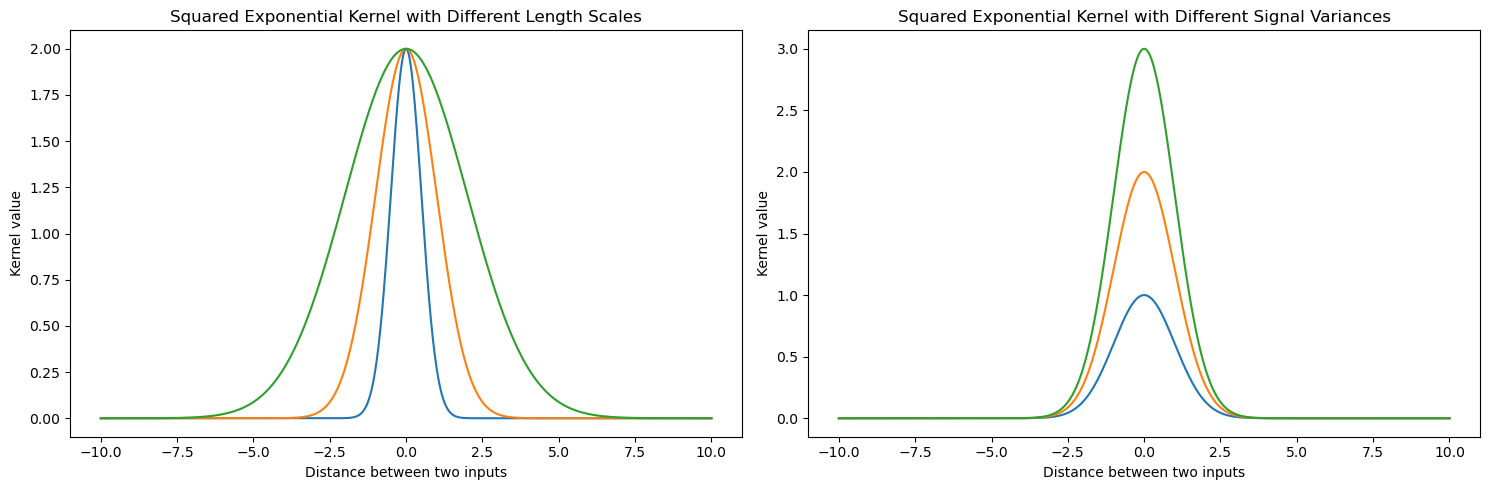

In [17]:
def kernelSE(x1, x2, lengthScale, signalVarianceSE):
    k = []
    for indx in range(x2.shape[1]):
        k = np.append(k,signalVarianceSE*np.exp(np.linalg.norm(x1-x2[:,indx])**2/(-2*lengthScale**2)))
    # print(x1 - x2)
    # print(np.linalg.norm(x1-x2))
    # k = signalVarianceSE * np.exp(-np.linalg.norm(x1-x2)**2/(2*lengthScale**2)) # Simply define the norm like this, the values are scalars thus we do not need to take the norm and loop since the operation x1-x2 returns a matrix with x1 -x2_i anyway
    return k

lengthScales = np.array([0.5, 1, 2])
signalVarianceSEs = np.array([1, 2, 3])

''' Code for plotting: Do not change code below '''
steps = 1000
p0 = np.zeros((1, 1))
PLine = np.linspace(-10, 10, steps).reshape(1, -1)

kValues = np.zeros((steps, 6))

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for indx, lengthScaleSquared in enumerate(lengthScales):
    kValues[:, indx] = kernelSE(p0, PLine, lengthScaleSquared, signalVarianceSEs[1])
    axs[0].plot(PLine[0, :], kValues[:, indx])

for indx, signalVariancePeriod in enumerate(signalVarianceSEs):
    kValues[:, indx + 3] = kernelSE(p0, PLine, lengthScales[1], signalVariancePeriod)
    axs[1].plot(PLine[0, :], kValues[:, indx + 3])

axs[0].set_title("Squared Exponential Kernel with Different Length Scales")
axs[0].set_xlabel("Distance between two inputs")
axs[0].set_ylabel("Kernel value")
axs[1].set_title("Squared Exponential Kernel with Different Signal Variances")
axs[1].set_xlabel("Distance between two inputs")
axs[1].set_ylabel("Kernel value")

plt.tight_layout()
plt.show()


#### Sampling from a Gaussian process prior
Sampling from a Gaussian process can be useful, for e.g. creating artificial datasets. Let us continue with the squared exponential kernel (although this extends to all valid kernels). Using this kernel, we can make a kernel matrix as

$$
\mathbf{K}_{\text{se}}(\mathbf{P}_{1:\text{T}}, \mathbf{P}_{1:\text{T}}) = 
\begin{bmatrix} \kappa_{\text{se}}(\mathbf{p}_{1}, \mathbf{p}_{\text{1}})  & \dots & \kappa_{\text{se}}(\mathbf{p}_{1}, \mathbf{p}_{\text{T}}) \\
\vdots & \ddots & \vdots \\
\kappa_{\text{se}}(\mathbf{p}_{\text{T}}, \mathbf{p}_{1}) & \dots & \kappa_{\text{se}}(\mathbf{p}_{\text{T}}, \mathbf{p}_{\text{T}})
\end{bmatrix}
$$

The prior covariance kernel for all prediction locations $\mathbf{P}_{\star}$ then becomes

$$
\begin{aligned}
\mathbf{f}_{\star} &\sim \mathcal{N}\left(0, \mathbf{K}(\mathbf{P}_{\star},\mathbf{P}_{\star})\right), \\
 &\sim \mathcal{N}\left(0, \mathbf{L} \mathbf{L}^{\text{T}}\right) 
\end{aligned}
$$

Where $\mathbf{L}$ denotes the (lower triangular) cholesky decomposition

$$
\mathbf{f}_{\star} = \mathbf{L}\mathbf{z}, \quad \mathbf{z} \sim \mathcal{N}\left(0, \mathbf{I} \right)  \\
$$

For more details see e.g. (https://gaussianprocess.org/gpml/)

#### Task:

Using the Cholesky decomposition, fill in the function `samplingFromPrior`, such that you can sample `Nsamples` function evaluations from a GP prior with the squared exponential kernel.



#### Analysis:

Elaborate on what happens in the plot when you change the values of the two parameters

- lengthScaleSquared
- signalVarianceSE

### Analysis Answer

As might be expected, if we increase the lengthScaleSquared, what we are intuitively doing is we ensuring that the cross-covariance between the different points is higher. This higher degree of cross-covariance means that the different variables are more related and thus that they will vary less across input. What this does is "increases the length scale" by ensuring that we have the same (average) evolution of our Gaussian process over larger and larger length scales, hence the name. One can also regard this as increasing the "smoothness" of our function

Increasing the signal variance very simply increases the amount of noise between the different samples. Another way of viewing this is by saying that by increasing the variance of the noise, we are basically increasing the bounds within which our function will likely fall. If the variance is low we see that the function will oscillate close to our mean, whereas as we increase the variance, the oscillations will deviate further and further from the mean, as might be expected. At zero variance we of course have a perfect line at the mean (zero).

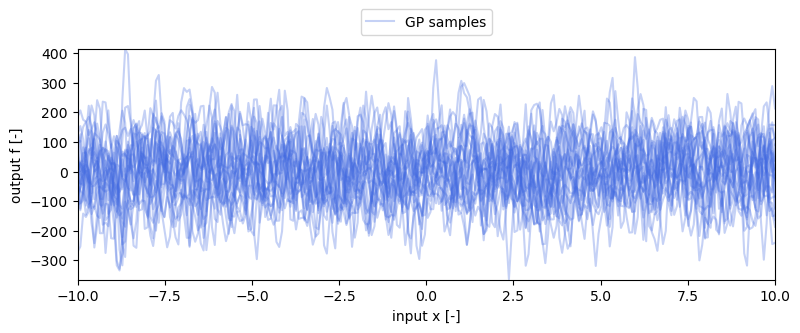

In [18]:

def kernelMatrixSE(X1, X2, lengthScaleSquared, signalVarianceSE):
    K = np.empty((X1.shape[1],X2.shape[1])) # Initialize the matrix as a p*p matrix
    l2 = lengthScaleSquared
    sigma = signalVarianceSE
    diff = X1.T - X2 # Create a matrix of the difference between a row and column vector
    K = sigma**2*np.exp(diff**2/(-2*l2))
    return K

def samplingFromPrior(Xprior, lengthScaleSquared, signalVariance):
    l2 = lengthScaleSquared
    sigma = signalVariance
    KM = kernelMatrixSE(Xprior,Xprior,l2,sigma)
    L = linAlg.chol(KM)
    z = np.random.normal(0,1,Xprior.shape[1])
    fPrior = L@z
    return fPrior.reshape(-1, 1)

lengthScaleSquared = 0.1**2
signalVariancePeriod = 100


''' Code for plotting: Do not change'''
posPred1D = np.linspace(-10, 10, 250).reshape(1, -1)
Nsamples = 25
fPriorSamples = np.zeros((Nsamples, 250))
fPosteriorSamples = np.zeros((Nsamples, 250))
for samplendx in range(Nsamples):
    fPriorSamples[samplendx, :] = samplingFromPrior(posPred1D, lengthScaleSquared, signalVariancePeriod).ravel()

helper.makeGaussianProcessSamplingPlots(posPred1D, fPriorSamples)


#### Gaussian process predictions

Previously, we considered the case where our data has no measurement noise. Below we show the derivation for the case when we have noisy data, which leads to joint distribution

$$
\begin{bmatrix}
\mathbf{y}_{1:\text{T}} \\
\mathbf{f}_{\star}
\end{bmatrix}
\sim \mathcal{N}\left(
\mathbf{0},
\begin{bmatrix}
\mathbf{K}(\mathbf{P}_{1:\text{T}}, \mathbf{P}_{1:\text{T}}) + \sigma^2_{\text{y}} \mathbf{I}_{\text{T}} & \mathbf{K}(\mathbf{P}_{1:\text{T}}, \mathbf{p}_{\star}) \\
\mathbf{K}(\mathbf{p}_{\star}, \mathbf{P}_{1:\text{T}}) & \mathbf{K}(\mathbf{p}_{\star}, \mathbf{p}_{\star})
\end{bmatrix}
\right)
$$

The joint distribution leads to the predictive mean and covariance as

$$
\begin{aligned} \mathbb{E}[f(\mathbf{p}_{\star})] &= \mathbf{K}(\mathbf{p}_{\star}, \mathbf{P}_{1:\text{T}}) \left(\mathbf{K}(\mathbf{P}_{1:\text{T}}, \mathbf{P}_{1:\text{T}}) +  \sigma^2_{\text{y}} \mathbf{I}_{\text{T}} \right)^{-1}\mathbf{y}_{1:\text{T}}, \\
\mathbb{V}[f(\mathbf{p}_{\star})] &= \mathbf{K}(\mathbf{p}_{\star}, \mathbf{P}_{1:\text{T}}) \left(\mathbf{K}(\mathbf{P}_{1:\text{T}}, \mathbf{P}_{1:\text{T}}) +  \sigma^2_{\text{y}} \mathbf{I}_{\text{T}} \right)^{-1} \mathbf{K}(\mathbf{P}_{1:\text{T}}, \mathbf{p}_{\star}) 
\end{aligned}$$

However, in practice, the inversion can be numerically unstable, to improve stability we use the Cholesky decomposition from \cite{}: 

$$ 
\begin{aligned} \mathbf{L} &:= \text{chol}\left( \mathbf{K}(\mathbf{P}_{1:\text{T}}, \mathbf{P}_{1:\text{T}}) +  \sigma^2_{\text{y}} \mathbf{I}_{\text{T}} \right), \\
\mathbf{a} &:= (\mathbf{L}^{\text{T}})^{-1} \left(\mathbf{L}^{-1} \mathbf{y}_{1:\text{T}} \right), \\
\mathbf{v} &:= \mathbf{L}^{-1} \mathbf{K}(\mathbf{P}_{1:\text{T}}, \mathbf{p}_{\star}), \\
\mathbb{E}[f(\mathbf{p}_{\star})] &:= \mathbf{K}(\mathbf{p}_{\star}, \mathbf{P}_{1:\text{T}}) \mathbf{a}, \\
\mathbb{V}[f(\mathbf{p}_{\star})] &:= \mathbf{K}(\mathbf{p}_{\star}, \mathbf{p}_{\star}) - \mathbf{v}^{\text{T}} \mathbf{v}  
\end{aligned}$$

#### Task:

- Finish the implementation of `predictSE`, such that you can predict the mean and covariance of the posterior GP, at given test locations $\mathbf{P}_{\star}$.

- By hand, tune the hyper-parameters `lengthScaleSquared`, `signalVarianceSE` `noiseVariance`, to make predictions on the give dataset.

#### Analysis:

Elaborate on the quality of the prediction on the left half of the figure and the right half of the figure. 
- How well does it predict the latent function?


### Analysis answer
The Gaussian Process gives a very bad prediciton of the resulting function. This makes sense since the underlying function is actually periodic while the Gaussian process prediction is purely, well, Gaussian. We do not take advantage of the structure of the underlying function and thus we can predict the points between our measurements relatively well but as soon as we "run out" of measurements, the random Gaussian process with mean zero takes over and our predictions deviate from the actual function. And take on the properties of zero mean and sigma variance.

From specifically, on the left side of the figure the GP makes reasonable predictions of the underlying process. If we were to take the length scale shorter, we could create a GP posterior for which the predictions are quite poor, however this gives good predictions. We do however see that when measurements are fewer (far right of the figure) that the predictions are again poor.

On the right side of the figure, as stated before, we regress to the GP prior with zero mean and $\sigma^2$ variance.

(25, 25)


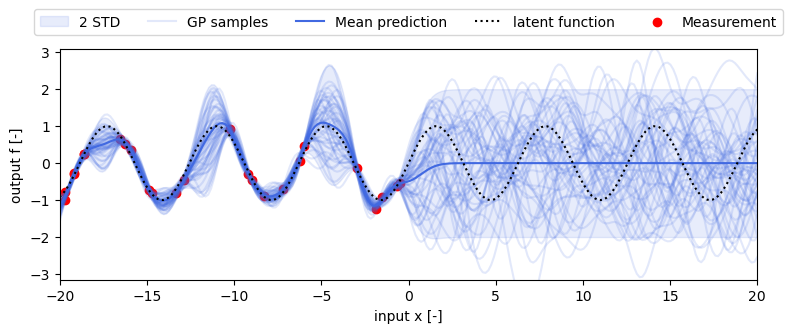

In [19]:
def predictSE(Xstar, X, y, lengthScaleSquared, signalVarianceSE, noiseVariance):
    Xstar
    l = lengthScaleSquared
    sigmaP = signalVarianceSE
    sigmaY = noiseVariance
    K_star_star = kernelMatrixSE(Xstar,Xstar,l,sigmaP)
    K_star =kernelMatrixSE(Xstar,X,l,sigmaP)
    K = kernelMatrixSE(X,X,l,sigmaP)
    noiseMatrix = sigmaY*np.eye(X.shape[1])
    L = linAlg.chol(K+noiseMatrix)
    Linv = linAlg.sinv(L)
    print(L.shape)
    a = Linv.T@(Linv@y)
    v = Linv@K_star.T
    mean = K_star@a
    cov = K_star_star - v.T@v
    return mean, cov

lengthScaleSquared = 1
signalVariancePeriod = 1
noiseVariance = 0.01


''' Code for plotting: Do not change code below '''
posData1D = np.random.uniform(-20, 0, 25).reshape(1, -1)
posPred1D = np.linspace(-20, 20, 250).reshape(1, -1)
yData1D = helper.generateData(posData1D, 'sin')


f, cov = predictSE(posPred1D, posData1D, yData1D, lengthScaleSquared, signalVariancePeriod, noiseVariance)
helper.makeGaussianProcessPredictionPlots(posData1D, yData1D, posPred1D, f, cov, 'sin')

#### Sampling from a Gaussian Process Posterior

As we are usually not interested in the prior, we want to incorporate data. Let's consider some noise-free data, we can then make a joint distribution over both the training and test points:



$$
\begin{bmatrix}
\mathbf{f}_{1:\text{T}} \\
\mathbf{f}_{\star}
\end{bmatrix}
\sim \mathcal{N}\left(
\mathbf{0},
\begin{bmatrix}
\mathbf{K}(\mathbf{P}_{1:\text{T}}, \mathbf{P}_{1:\text{T}}) & \mathbf{K}(\mathbf{P}_{1:\text{T}}, \mathbf{p}_{\star}) \\
\mathbf{K}(\mathbf{p}_{\star}, \mathbf{P}_{1:\text{T}}) & \mathbf{K}(\mathbf{p}_{\star}, \mathbf{p}_{\star})
\end{bmatrix}
\right)
$$

This allows us to compute the posterior distribution of a Gaussian Process (GP). Below are the posterior mean $ \mathbf{\mu}_{\star} $ and posterior covariance $ \mathbf{\Sigma}_{\star} $


$$
\begin{aligned}
\mathbf{\mu}_{\star} &= \mathbf{K}(\mathbf{p}_{\star}, \mathbf{P}_{1:\text{T}}) \mathbf{K}(\mathbf{P}_{1:\text{T}}, \mathbf{P}_{1:\text{T}})^{-1} \mathbf{f}_{1:\text{T}}, \\

\mathbf{\Sigma}_{\star} &= \mathbf{K}(\mathbf{p}_{\star}, \mathbf{p}_{\star}) - \mathbf{K}(\mathbf{p}_{\star}, \mathbf{P}_{1:\text{T}}) \mathbf{K}(\mathbf{P}_{1:\text{T}}, \mathbf{P}_{1:\text{T}})^{-1} \mathbf{K}(\mathbf{P}_{1:\text{T}}, \mathbf{p}_{\star})
\end{aligned}
$$

Again, using $\mathbf{L} \mathbf{L}^{\text{T}} = \left(\mathbf{\Sigma}_{\star} \right)$ we can write

$$
\mathbf{f}_{\star} = \mu_{\star} + \mathbf{L}\mathbf{z}, \quad \mathbf{z} \sim \mathcal{N}\left(0, \mathbf{I} \right)  \\
$$

#### Task:

Fill in the function `samplingFromPosterior`, such that you can sample `Nsamples` function evaluations from a GP prior with the squared exponential kernel.

#### Analysis:

Elaborate on what happens in the plot when you change the values of the two parameters

- lengthScaleSquared
- signalVarianceSE

### Analysis Answers

As we increase the variance, as we might expect, the Gaussian process deviates more and more from the mean. To further discuss we first look at our "measurements" or in other words points that we generate from a sample of our prior. We can regard this points as random points found along the line of a sample generated via a Gaussian prior, notably also with the same length scale and signal variance. As we increase the length scale these points will become "smoother" (or at least the function connecting the points) and as we increase the variance the points will deviate further from the mean (zero).

The same effect happens with the posterior of the Gaussian, we see that as we increase the variance, the function will deviate further and further from the mean between points, while if we decrease the lengthscale, it does so more and more eratically. The reasons why we have discussed before. In our case the prior and our posterior use the same values for the variance and the length scale, and thus they correspond quite closely to eachother (or at least, the posterior models the behaviour of the random prior pretty much perfectly). If this were different, we would either see a very random prior but smooth posterior, or vice-versa which might not be desirable.

Of course, with so few measurements, it is difficult to reconstruct an accurate model of the underlying function and we are simply filling the missing points. With more and more measurements we could reconstruct some structure, or if we know more about the underlying function (periodicity, increase linearly etc.) we could build this into our prior.

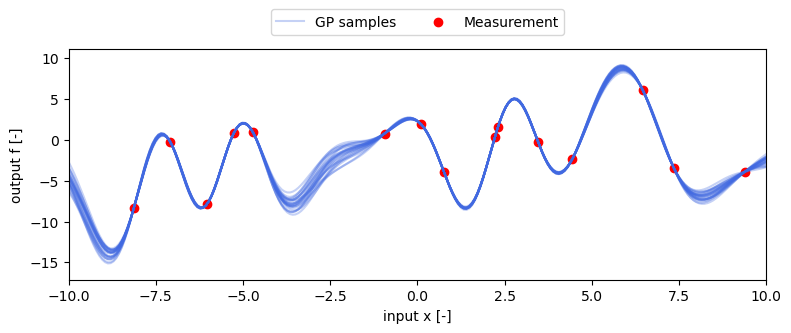

In [20]:
def samplingFromPosterior(Xposterior, Xprior, fprior, lengthScaleSquared, signalVariance):
    l = lengthScaleSquared
    sigma = signalVariance
    K = kernelMatrixSE(Xprior,Xprior,l,sigma)
    K_star = kernelMatrixSE(Xposterior,Xprior,l,sigma)
    K_star_star = kernelMatrixSE(Xposterior,Xposterior,l,sigma)
    # Notice how we use Cholsky decomposition for stability

    LK = linAlg.chol(K)
    LKinv = linAlg.sinv(LK)
    Kinv = LKinv.T@LKinv
    mu_star = K_star@Kinv@fprior
    Sigma_star = K_star_star - K_star@Kinv@K_star.T
    L = linAlg.chol(Sigma_star)
    z = np.random.normal(0,1,Xposterior.shape[1])
    samples = mu_star.flatten() + L@z
    return samples.flatten()

sampleLengthScaleSquared = 0.1
sampleSignalVariancePeriod = 5
posteriorLengthScaleSquared = 0.1
priorSignalVariancePeriod = 2

''' Code for plotting: Do not change code below '''
posData1D = np.random.uniform(-10, 10, 15).reshape(1, -1)
fData = samplingFromPrior(posData1D, sampleLengthScaleSquared, sampleSignalVariancePeriod)

posPred1D = np.linspace(-10, 10, 250).reshape(1, -1)
Nsamples = 25
fPriorSamples = np.zeros((Nsamples, 250))
for samplendx in range(Nsamples):
    fPosteriorSamples[samplendx, :] = samplingFromPosterior(posPred1D, posData1D, fData, lengthScaleSquared, signalVariancePeriod).ravel()

helper.makeGaussianProcessSamplingPlots(posPred1D, fPosteriorSamples, posData1D, fData)


#### Periodic kernel

There are many kernels to choose from and it is up to the engineer to choose the right kernel for the right task. A list of different kernels can be found in the kernel cookbook (https://www.cs.toronto.edu/~duvenaud/cookbook/). A better suited kernel for the previously given data might be a periodic kernel, which can be described with
$$\kappa_{\text{per}}(\mathbf{p},\mathbf{p}') = \sigma^2_{\text{per}}  \text{exp} \left( \frac{\text{sin} \left( \pi \frac{|\mathbf{p} - \mathbf{p}'|}{\text{period}} \right)^2 }{-0.5 l^2} \right)$$


#### Task:

- Given the periodic kernel above, finish the implementation of the functions `kernelPeriodic`, `kernelMatrixPeriodic` and `predictPeriodic`.

- Manually tune the hyper-parameters `lengthScaleSquared`, `signalVariancePeriod`, `noiseVariance`, and  `period`.


#### Analysis:

Elaborate on the quality of the prediction on the left half of the figure and the right half of the figure.
- How well does it predict the latent function? 
- How does it compare to the prediction of the SE kernel

- As seen in the plot below the periodic kernel follows the latent function very well. With the measurements the prediction using the periodic kernel follows the latent function and this continous after the measurement stop. The GP confidence band is very tight which indicates high certainty,=.
- Looking at the SE kernel, it can be seen that the predections are way more chaotic. The GP samples are highly fluctuating meaning the kernel is struggeling to generalize. It can also be seen that the uncertainty is very high especially in parts with fewer measurements. 

C:\Users\tomli\AppData\Local\Temp\ipykernel_15180\1525930311.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K[i,j] = kernelPeriodic(X1[:,i], X2[:,j], lengthScaleSquared, signalVariancePeriod, period)
c:\Users\tomli\Documents\S&C\Semester 3\Probabilistic Sensor Fusion\Github\Probabilistic-Sensor-Fusion\Probabilistic-Sensor-Fusion\Assignment3\helper.py:177: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(f.flatten(), cov, numSamples)


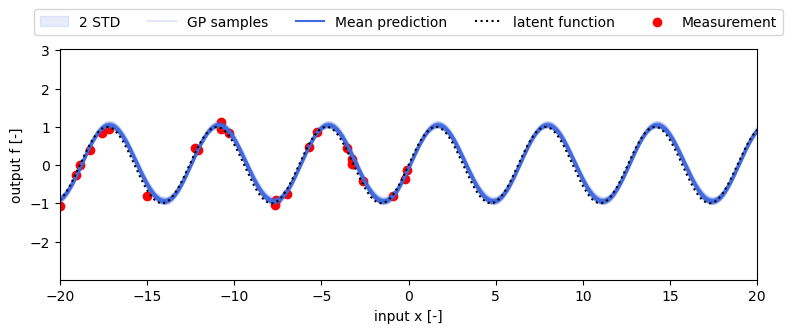

In [21]:
def kernelPeriodic(x1, x2, lengthScaleSquared, signalVariancePeriod, period):
    k = signalVariancePeriod * np.exp( ( np.sin(np.pi * (abs(x1 - x2)) / period)**2) / -0.5 * lengthScaleSquared)
    return k

def kernelMatrixPeriodic(X1, X2, lengthScaleSquared, signalVariancePeriod, period):
    K = np.zeros((np.size(X1), np.size(X2)))
    for i in range(np.size(X1)):  
        for j in range(np.size(X2)):  
            K[i,j] = kernelPeriodic(X1[:,i], X2[:,j], lengthScaleSquared, signalVariancePeriod, period)
    return K

def predictPeriodic(Xstar, X, y, lengthScaleSquared, signalVariancePeriod, period, noiseVariance):
    Kstar1 = kernelMatrixPeriodic(Xstar, X, lengthScaleSquared, signalVariancePeriod, period)
    Kstar2 = kernelMatrixPeriodic(X, Xstar, lengthScaleSquared, signalVariancePeriod, period)
    K = kernelPeriodic(X, X, lengthScaleSquared, signalVariancePeriod, period)
    K2star = kernelMatrixPeriodic(Xstar, Xstar, lengthScaleSquared, signalVariancePeriod, period)
    mean = Kstar1 @ linAlg.sinv(K + noiseVariance * np.eye(np.size(X))) @ y
    cov = K2star - Kstar1 @ linAlg.sinv(K + noiseVariance * np.eye(np.size(X))) @ Kstar2
    return mean, cov


# lengthScaleSquared = .1
# signalVariancePeriod = 1
# noiseVariance = 0.01
# period = 4*np.pi
lengthScaleSquared = .1
signalVariancePeriod = 0.01
noiseVariance = 0.01
period = 2*np.pi

''' Code for plotting: Do not change code below '''
posData1D = np.random.uniform(-20, 0, 25).reshape(1, -1)
posPred1D = np.linspace(-20, 20, 250).reshape(1, -1)
yData1D = helper.generateData(posData1D, 'sin')

f, cov = predictPeriodic(posPred1D, posData1D, yData1D, lengthScaleSquared, signalVariancePeriod, period, noiseVariance)
helper.makeGaussianProcessPredictionPlots(posData1D, yData1D, posPred1D, f, cov, 'sin')

#### Linear + periodic kernel

Assume the observed data has a linear ascending trend. Using only periodic kernel will fail the prediction as shown below:

C:\Users\tomli\AppData\Local\Temp\ipykernel_15180\1525930311.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K[i,j] = kernelPeriodic(X1[:,i], X2[:,j], lengthScaleSquared, signalVariancePeriod, period)
c:\Users\tomli\Documents\S&C\Semester 3\Probabilistic Sensor Fusion\Github\Probabilistic-Sensor-Fusion\Probabilistic-Sensor-Fusion\Assignment3\helper.py:177: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(f.flatten(), cov, numSamples)


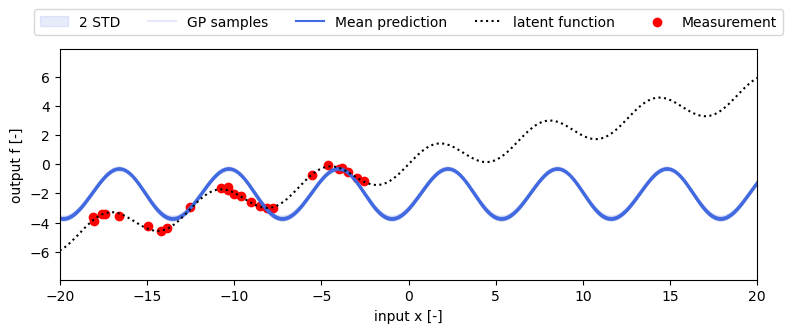

In [22]:
lengthScaleSquared = .1
signalVariancePeriod = 0.015
noiseVariance = 0.01
period = 2*np.pi
signalVarianceLin = .25


''' Code for plotting: Do not change code below '''
posData1D = np.random.uniform(-20, 0, 25).reshape(1, -1)
posPred1D = np.linspace(-20, 20, 250).reshape(1, -1)
yData1D_v2 = helper.generateData(posData1D, 'linsin', addNoise = True)
f, cov = predictPeriodic(posPred1D, posData1D, yData1D_v2, lengthScaleSquared, signalVariancePeriod, period, noiseVariance)
helper.makeGaussianProcessPredictionPlots(posData1D, yData1D_v2, posPred1D, f, cov, 'linsin')

In this case, it is also possible to combine kernels, for now we will stick with addition (for all mathematical properties see the kernel cookbook https://www.cs.toronto.edu/~duvenaud/cookbook/). In this example, we will add a periodic kernel and a linear kernel, the latter is defined as



$$
\kappa_{\text{lin}} = \sigma^2_{\text{lin}} \mathbf{p}^{\text{T}} \mathbf{p}'
$$


#### Task:

- Given the periodic kernel above, finish the implementation of the funcitons `kernelLin`, `kernelMatrixLin` and `predictLinPeriodic`.

- Manually tune the hyper-parameters `lengthScaleSquared`, `signalVariancePeriod`, `noiseVariance`, `period` and `signalVarianceLin`.


#### Analysis:

Elaborate on the quality of the prediction on the left half of the figure and the right half of the figure.
- How well does it predict the latent function? 

#### Answer:
The linear and periodic kernel combination predicts the latent function nearly perfectly. If we simply adjust the linear term $\sigma^2$ term to be exactly equal to a linear regression line we take to the periodic original function (we find this to be about 0.3), and additionally we take the periodic of the periodic kernel to be the same as the underlying function, we can predict it pretty much exactly! Additionally of course $\sigma_p^2$ (variance of the periodic kernel) denotes how far from the linear term we deviate at each period.

For us the linear kernel was quite unintuitive (surprisingly). After all, if we were to look at the kernel we simply see (linearly) decreasing covariances as we move further away. Our question then was. What forces the linear kernel to take on a positive slope? The linear nature of the kernel is obvious, as we cannot have that highly uncorrelated values take the same values so naturally a straight line results, but why positive? And the simple answer is, there is no reason for a positive slope. In a linear kernel 50% of the samples would result in a positive slope, and 50% in a negative slope. Thus, simply because we are taking the measurements, do we result in a positive slope!

We are literally seeing that given this underlying structure, the posterior learns the underlying function!

In the current form of the linear kernel, we always take on values of 0 x = 0, since then the variance is zero and our mean is also zero. However, we can of course introduce an additional variable c, which dictates how high our function is at x = 0.

$$
\kappa_{\text{lin}} = \sigma^2_{\text{lin}} (\mathbf{p}-c)^T (\mathbf{p}'-c)
$$

C:\Users\tomli\AppData\Local\Temp\ipykernel_15180\1525930311.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K[i,j] = kernelPeriodic(X1[:,i], X2[:,j], lengthScaleSquared, signalVariancePeriod, period)
c:\Users\tomli\Documents\S&C\Semester 3\Probabilistic Sensor Fusion\Github\Probabilistic-Sensor-Fusion\Probabilistic-Sensor-Fusion\Assignment3\helper.py:177: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(f.flatten(), cov, numSamples)


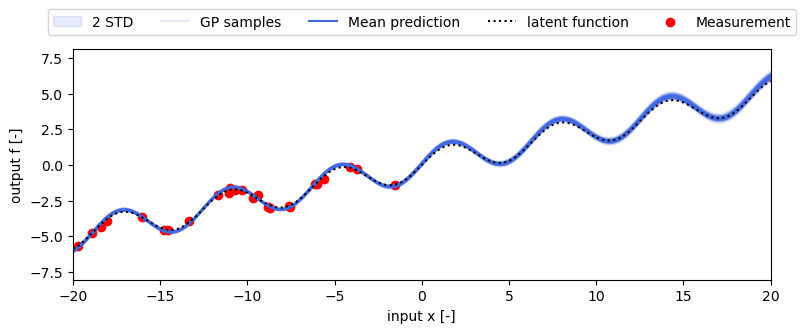

In [24]:
def kernelLin(x1, x2, sigmaSquaredLin):
    k = sigmaSquaredLin * x1.T @ x2
    return k

def kernelMatrixLin(X1, X2, signalVarianceLin):
    K = np.zeros((np.size(X1), np.size(X2)))
    for i in range(np.size(X1)):  
        for j in range(np.size(X2)):  
            K[i,j] = kernelLin(X1[:,i], X2[:,j], signalVarianceLin)
    return K

def predictLinPeriodic(Xstar, X, y, lengthScaleSquared, sigmaSquaredF, period, signalVarianceLin, noiseVariance):
    Kstar1 = kernelMatrixPeriodic(Xstar, X, lengthScaleSquared, sigmaSquaredF, period) + kernelMatrixLin(Xstar, X, signalVarianceLin)
    Kstar2 = kernelMatrixPeriodic(X, Xstar, lengthScaleSquared, sigmaSquaredF, period) + kernelMatrixLin(X, Xstar, signalVarianceLin)
    K = kernelPeriodic(X, X, lengthScaleSquared, sigmaSquaredF, period) + kernelMatrixLin(X, X, signalVarianceLin)
    K2star = kernelMatrixPeriodic(Xstar, Xstar, lengthScaleSquared, sigmaSquaredF, period) + kernelMatrixLin(Xstar, Xstar, signalVarianceLin)
    mean = Kstar1 @ linAlg.sinv(K + noiseVariance * np.eye(np.size(X))) @ y
    cov = K2star - Kstar1 @ linAlg.sinv(K + noiseVariance * np.eye(np.size(X))) @ Kstar2
    return mean, cov


lengthScaleSquared = .1
signalVariancePeriod = 0.01
noiseVariance = 0.01
period = 2*np.pi
signalVarianceLin = .3



''' Code for plotting: Do not change code below '''
posData1D = np.random.uniform(-20, 0, 25).reshape(1, -1)
posPred1D = np.linspace(-20, 20, 250).reshape(1, -1)
yData1D_v2 = helper.generateData(posData1D, 'linsin', addNoise = True)
f, cov = predictLinPeriodic(posPred1D, posData1D, yData1D_v2, lengthScaleSquared, signalVariancePeriod, period, signalVarianceLin, noiseVariance)
helper.makeGaussianProcessPredictionPlots(posData1D, yData1D_v2, posPred1D, f, cov, 'linsin')

### Optimising the Log Marginal Likelihood

Instead of manually tuning the hyper-parameters, which will be extremely tedious for large data-sets, the hyper-parmaeters can be optimised. This can be done by maximising the marginal log-likelihood with respect to the set of hyper-parameters $\theta$:

$$
\theta_{\text{ML}} = \text{arg} \max_\theta \underbrace{\log p(y|x)}_{\mathcal{L}} 
$$

With

$$
\mathcal{L} = - \frac{1}{2} \operatorname{tr} (\mathbf{y}_{t:T}^\text{T} \mathbf{K}_{\text{y}}  \mathbf{y}_{t:T}) - \frac{1}{2} \log |\mathbf{K}_{\text{y}} |  - \frac{T}{2} \log 2 \pi
$$

where 

$$
\mathbf{K}_{\text{y}} = \mathbf{K}(\mathbf{P}_{1:T}, \mathbf{P}_{1:T}) + \sigma^2_{\text{y}} \mathbf{I}_{T}
$$

Below, you are given the cost function and its gradient in the functions `GP.expLogML` and `GP.expGradLogML` respectively.

#### Task:
Initialize the hyper-parameters to orders of different magnitudes


#### Analysis:
- How can you find out whether the hyper parameter optimum is unique, or whether there maybe other local optima? 
- If there are local optima, find some, and explain what the model is doing in each case. Which fit is best, and why?


#### Note:
If you are interested in the under the hood functions: we re-paramaterise the hyper-parameters into the log space with $s = \text{log}(\theta)$ (not the log in the log marginal likelihood), which ensures non-negatives of the hyper-parameters and generally can be expected to have better perfomance when the initialisation of the hyper-parameters are far off.

Optimized length scale squared: 2.1831025453985617
Optimized sigma squared f: 0.6348425647680159
Optimized noise variance: 0.02180964021621169
(30, 30)


<Figure size 900x300 with 0 Axes>

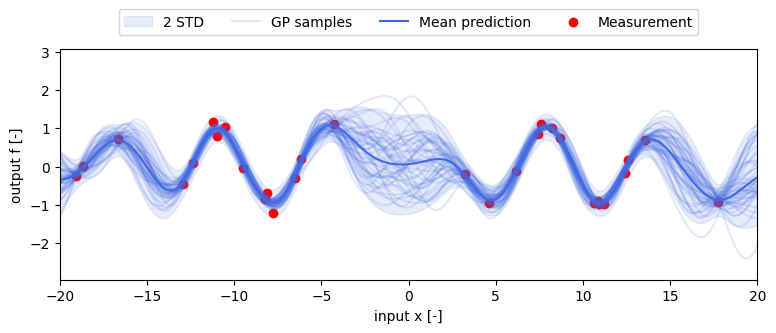

In [12]:

''' Define initial guess for the hyperparameters
    - lengthScaleSquared
    - signalVarianceSE
    - noiseVariance 
    then transform to log space ''' 

initialLengthScaleSquared = 3
initialSignalVarianceSE = 2
initialNoiseVariance = 1



''' Code for plotting: Do not change code below '''
s0 = np.log([initialLengthScaleSquared, initialSignalVarianceSE, initialNoiseVariance])

posDataOpt = np.hstack((np.random.uniform(-20, -3, 15).reshape(1, -1), np.random.uniform(3, 20, 15).reshape(1, -1)))
posPred = np.linspace(-20, 20, 250).reshape(1, -1)
yDataOpt = helper.generateData(posDataOpt, 'sin')

''' Optimize the hyperparameters using BFGS ''' 
result = opt.minimize(GP.expLogML, s0, jac=GP.expGradLogML, method='BFGS', args=(posDataOpt, yDataOpt))

''' Extract the optimized hyperparameters, transform back from log space ''' 
lengthScaleSquaredOpt = np.exp(result.x[0])
signalVarianceSEOpt = np.exp(result.x[1])
noiseVarianceOpt = np.exp(result.x[2])

print("Optimized length scale squared:", lengthScaleSquaredOpt)
print("Optimized sigma squared f:", signalVarianceSEOpt)
print("Optimized noise variance:", noiseVarianceOpt)

plt.figure(figsize=(9,3), dpi=100)

# f, cov = predictSE(posPred, posDataOpt, yDataOpt, initialLengthScaleSquared, initialSignalVarianceSE, initialNoiseVariance)
f, cov = predictSE(posPred, posDataOpt, yDataOpt, lengthScaleSquaredOpt, signalVarianceSEOpt, noiseVarianceOpt)
helper.makeGaussianProcessPredictionPlots(posDataOpt, yDataOpt, posPred, f, cov, 'none', noiseVarianceOpt)



#### Making a magnetic field plot

Based on what you have learned before, you are able to make your very first magnetic field map using Gaussian processes. Note that the magnetic field you will map consists of the Earth's magnetic field and disturbances induced by ferro-magnetic materials in indoor environments. These two components can be modeled by a constant kernel and a squared exponential kernel respectively. The constant kernel is defined as

$$
\kappa_{\text{con}}(\mathbf{p}, \mathbf{p}') = \sigma^2_{\text{con}} 
$$


#### First load in the data
To start, first load in the data below
All variables you will use are numpy arrays, where
- `magnetometerMeasurements` $\in \mathbb{R}^{3 \times \text{T}}$ is a numpy array containing the magnetometer measurements
- `magnetometerPositions` $\in \mathbb{R}^{3 \times \text{T}}$ is a numpy array containing the true positions of the magnetometer

#### Warning
- Additionally you are provided with a dictionary modelParameters which is used in creating magnetic field maps. DO NOT CHANGE dictionary as this might break the assignment. To create the magnetic field map you DO NOT need this dictionary.
The data is similar to the two previous assignments. Although this time, you may assumes you have access to all the true magnetometer positions.

In [19]:
''' load in the data'''
(magnetometerMeasurements, 
 magnetometerPositions,
 modelParameters) = helper.initializeGaussianProcessAssignment(groupNumber % 29)

#### Task:

- Implement the functions `kernelCon`, `kernelMatrixCon` and `predictGPmagneticField`.
To begin, you may start with the hyper-parameters
- `lengthScaleSquared` = 0.1**2
- `signalVariancePeriod` = 10**2 
- `noiseVariance` =  0.001
- `signalVarianceCon` = 1**2

Manually tune the hyper-parameters so the magnetic field on the right is similar to the magnetic field on the left. They are approximately in the correct order of magnitude.

#### Note:
The reference map is created by inducing the curl-free assumption of the magnetic field in the Gaussian process model, which leeads to a 3D output of the GP predicitons. As this is beyond the scope of this assignment, you may simplify the problem by first taking the norm of the magnetic field measurements. 

#### Analysis:

Elaborate on the physical interpretation of the hyper-parameters in the context of magnetic field mapping.


(625, 1)
(625, 625)


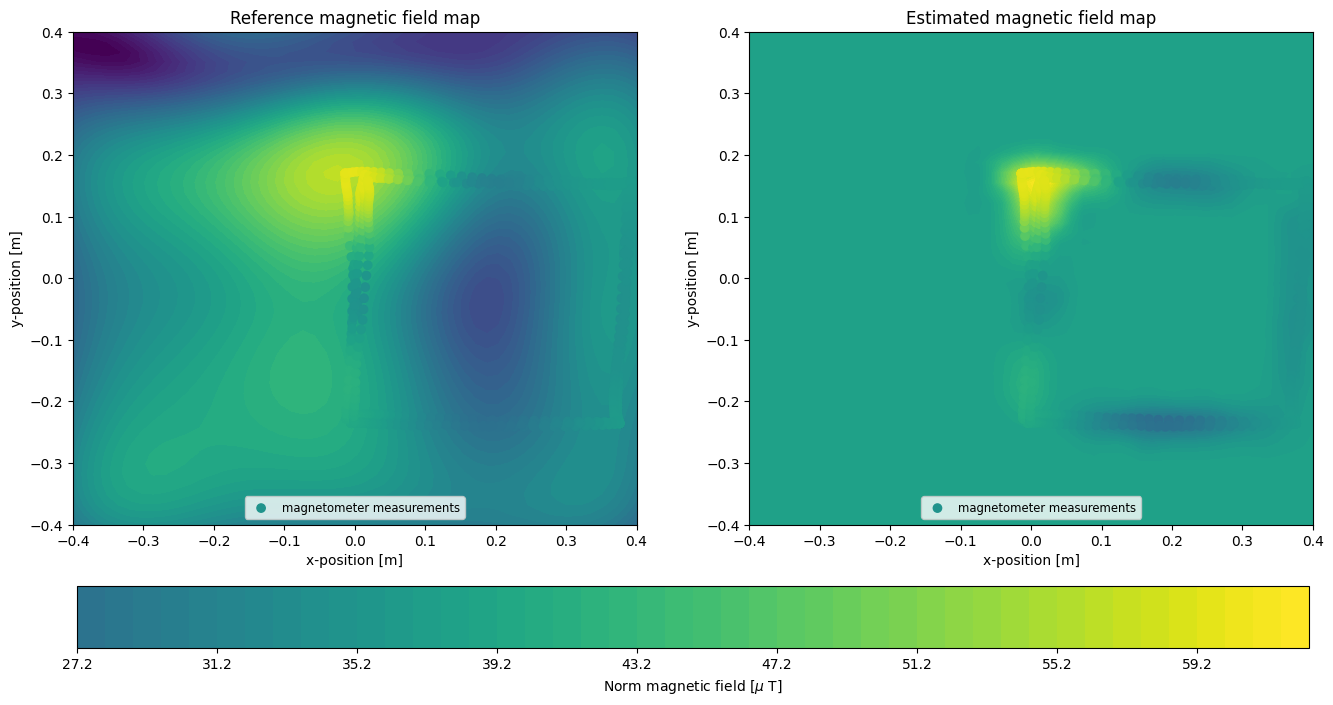

In [84]:
def kernelCon(x1, x2, signalVarianceCon):
    k = signalVarianceCon
    return k

def kernelMatrixCon(X1, X2, sigmaSquaredCon):
    K = np.ones((X1.shape[1], X2.shape[1])) * sigmaSquaredCon
    return K

def predictGPmagneticField(Xstar, X, y, lengthScaleSquared, sigmaSquaredF, noiseVariance, sigmaSquaredCon):

    Kstar1 = kernelMatrixCon(Xstar, X, sigmaSquaredCon) + kernelMatrixSE(Xstar, X, lengthScaleSquared, sigmaSquaredF)
    Kstar2 = kernelMatrixCon(X, Xstar, sigmaSquaredCon) + kernelMatrixSE(X, Xstar, lengthScaleSquared, sigmaSquaredF)
    K = kernelMatrixCon(X, X, sigmaSquaredCon) + kernelMatrixSE(X, X, lengthScaleSquared, sigmaSquaredF)
    K2star = kernelMatrixCon(Xstar, Xstar, sigmaSquaredCon) + kernelMatrixSE(Xstar, Xstar, lengthScaleSquared, sigmaSquaredF)
    
    mean = Kstar1 @ linAlg.sinv(K + noiseVariance * np.eye(X.shape[1])) @ y
    mean = mean.reshape(-1, 1)
    cov = K2star - Kstar1 @ linAlg.sinv(K + noiseVariance * np.eye(X.shape[1])) @ Kstar2
    print(mean.shape)
    print(cov.shape)
    return mean, cov


magnetomerNorm = np.linalg.norm(magnetometerMeasurements, axis=0)


# lengthScaleSquared = 0.1**2
# signalVariancePeriod = 1**2 
# noiseVariance =  0.001
# signalVarianceCon = 10**2


lengthScaleSquared = 0.015**2
signalVariancePeriod = 2**2 
noiseVariance =  0.001
signalVarianceCon = 10**2

''' Code for plotting: Do not change code below '''
posPred = linAlg.gridpointsHyperCube(25, 2, 3, np.array([[-0.4, 0.4],[-0.4, 0.4]]))
f, cov = predictGPmagneticField(posPred, magnetometerPositions, magnetomerNorm, lengthScaleSquared, signalVariancePeriod, noiseVariance, signalVarianceCon)
helper.makeGaussianProcessMagneticFieldMapPlots(magnetometerPositions, posPred, f, cov, magnetomerNorm, modelParameters)

#### Feedback:
This is the first year we are teaching this course. Your feedback will be invaluable in improving it for the coming years. Please let us know in this markdown any comments, suggestions or errors you have encountered in the last three assignments.  
